# KITTI Semantic Segmentation Project
이 노트북은 프로젝트의 모든 소스 코드를 하나로 통합한 것입니다.
데이터 로드, 모델 정의, 학습, 평가 및 비교를 순차적으로 실행할 수 있습니다.

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imageio import imread
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from skimage.transform import resize
import cv2
from albumentations import HorizontalFlip, Compose, Resize, ColorJitter
from scipy.ndimage import distance_transform_edt




In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
!unzip data_semantics.zip

--2025-12-01 16:42:45--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.93, 52.219.168.27, 3.5.137.254, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  60.8MB/s    in 5.0s    

2025-12-01 16:42:51 (62.2 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]

Archive:  data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  

## Data Augmentation Utils

In [ ]:
import os
from glob import glob
from imageio import imread
import matplotlib.pyplot as plt
from albumentations import HorizontalFlip, Compose, Resize, ColorJitter


def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            ColorJitter(              # 채도, 명도, 대비 변경 (image만 적용)
                brightness=0.2,       # 명도 ±20%
                contrast=0.2,         # 대비 ±20%
                saturation=0.2,       # 채도 ±20%
                hue=0.1,              # 색조 ±10%
                p=0.8                 # 80% 확률로 적용
            ),
            Resize(                   # 원본 비율 유지 (약 3:1), U-Net에 최적화된 크기
                width=768,
                height=256
            )
        ], additional_targets={'mask': 'mask'})  # mask도 함께 transform
    return Compose([      # 테스트용 데이터일 경우에는 768x256으로 resize만 수행합니다.
        Resize(
            width=768,
            height=256
        )
    ], additional_targets={'mask': 'mask'})


## Dataset Class

In [ ]:
import os
from glob import glob
import numpy as np
import torch
from imageio import imread
from torch.utils.data import Dataset


class KittiDataset(Dataset):
    def __init__(self,
                 dir_path,
                 is_train=True,
                 augmentation=None,
                 num_classes=34,
                 split_ratio=0.9):
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.num_classes = num_classes
        self.split_ratio = split_ratio

        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = sorted(glob(os.path.join(self.dir_path, "image_2", "*.png")))
        label_images = sorted(glob(os.path.join(self.dir_path, "semantic", "*.png")))

        assert len(input_images) == len(label_images), \
            f"이미지 개수({len(input_images)})와 라벨 개수({len(label_images)})가 다릅니다!"

        data = list(zip(input_images, label_images))

        total_len = len(data)
        train_len = int(total_len * self.split_ratio)

        if self.is_train:
            return data[:train_len]
        return data[train_len:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_img_path, output_path = self.data[index]

        _input = imread(input_img_path)
        _output = imread(output_path)

        _output = _output.astype(np.int64)

        data = {
            "image": _input,
            "mask": _output,
        }

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented["image"] / 255.0
            _output = augmented["mask"]
        else:
            _input = _input / 255.0

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),
            torch.tensor(_output, dtype=torch.long)
        )


## Model Architectures

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=34, bilinear=False):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return logits


class NestedUp(nn.Module):
    def __init__(self, in_channels, out_channels, n_concat=2):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels // 2 * n_concat, out_channels)

    def forward(self, *inputs):
        x = self.up(inputs[0])
        skip_connections = list(inputs[1:])
        x = torch.cat([x] + skip_connections, dim=1)
        return self.conv(x)


class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, num_classes=34, deep_supervision=False):
        super(UNetPlusPlus, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.deep_supervision = deep_supervision

        filters = [64, 128, 256, 512, 1024]

        self.conv0_0 = DoubleConv(in_channels, filters[0])
        self.pool0 = nn.MaxPool2d(2)

        self.conv1_0 = DoubleConv(filters[0], filters[1])
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_0 = DoubleConv(filters[1], filters[2])
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_0 = DoubleConv(filters[2], filters[3])
        self.pool3 = nn.MaxPool2d(2)

        self.conv4_0 = DoubleConv(filters[3], filters[4])

        self.up1_0 = NestedUp(filters[1], filters[0], n_concat=2)
        self.up2_1 = NestedUp(filters[2], filters[1], n_concat=2)
        self.up3_2 = NestedUp(filters[3], filters[2], n_concat=2)
        self.up4_3 = NestedUp(filters[4], filters[3], n_concat=2)

        self.up1_1 = NestedUp(filters[1], filters[0], n_concat=3)
        self.up2_2 = NestedUp(filters[2], filters[1], n_concat=3)
        self.up3_3 = NestedUp(filters[3], filters[2], n_concat=3)

        self.up1_2 = NestedUp(filters[1], filters[0], n_concat=4)
        self.up2_3 = NestedUp(filters[2], filters[1], n_concat=4)

        self.up1_3 = NestedUp(filters[1], filters[0], n_concat=5)

        if self.deep_supervision:
            self.final1 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(filters[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool0(x0_0))
        x2_0 = self.conv2_0(self.pool1(x1_0))
        x3_0 = self.conv3_0(self.pool2(x2_0))
        x4_0 = self.conv4_0(self.pool3(x3_0))

        x0_1 = self.up1_0(x1_0, x0_0)
        x1_1 = self.up2_1(x2_0, x1_0)
        x2_1 = self.up3_2(x3_0, x2_0)
        x3_1 = self.up4_3(x4_0, x3_0)

        x0_2 = self.up1_1(x1_1, x0_0, x0_1)
        x1_2 = self.up2_2(x2_1, x1_0, x1_1)
        x2_2 = self.up3_3(x3_1, x2_0, x2_1)

        x0_3 = self.up1_2(x1_2, x0_0, x0_1, x0_2)
        x1_3 = self.up2_3(x2_2, x1_0, x1_1, x1_2)

        x0_4 = self.up1_3(x1_3, x0_0, x0_1, x0_2, x0_3)

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            output = self.final(x0_4)
            return output


## Loss Functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt
import numpy as np


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, num_classes=34, ignore_index=0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)

        target_one_hot = F.one_hot(target, num_classes=self.num_classes)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()

        if self.ignore_index is not None:
            mask = (target != self.ignore_index).float().unsqueeze(1)
            pred = pred * mask
            target_one_hot = target_one_hot * mask

        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        if self.ignore_index is not None:
            valid_classes = [i for i in range(self.num_classes) if i != self.ignore_index]
            dice = dice[:, valid_classes].mean()
        else:
            dice = dice.mean()

        dice_loss = 1.0 - dice
        return dice_loss


class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, num_classes=34, ignore_index=0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, ignore_index=self.ignore_index, reduction='none')
        p = F.softmax(pred, dim=1)

        target_one_hot = F.one_hot(target, num_classes=self.num_classes)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()

        p_t = (p * target_one_hot).sum(dim=1)

        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()


class FocalDiceLoss(nn.Module):
    def __init__(self, num_classes=34, focal_alpha=1.0, focal_gamma=2.0, smooth=1.0, ignore_index=0):
        super(FocalDiceLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, num_classes=num_classes, ignore_index=ignore_index)
        self.dice_loss = DiceLoss(smooth=smooth, num_classes=num_classes, ignore_index=ignore_index)

    def forward(self, pred, target):
        focal = self.focal_loss(pred, target)
        dice = self.dice_loss(pred, target)
        total_loss = focal + dice

        loss_dict = {
            'total_loss': total_loss.item(),
            'focal_loss': focal.item(),
            'dice_loss': dice.item()
        }
        return total_loss, loss_dict


## Evaluation Metrics

In [ ]:
import numpy as np
import torch
import cv2

def compute_iou(pred, target, num_classes=34, ignore_index=0):
    if isinstance(pred, torch.Tensor):
        pred = pred.cpu().numpy()
    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()

    ious = []
    class_iou = {}

    for cls in range(num_classes):
        if cls == ignore_index:
            continue

        pred_mask = pred == cls
        target_mask = target == cls

        if target_mask.sum() == 0:
            continue

        intersection = np.logical_and(pred_mask, target_mask).sum()
        union = np.logical_or(pred_mask, target_mask).sum()

        iou = intersection / (union + 1e-7)
        ious.append(iou)
        class_iou[cls] = iou

    miou = np.mean(ious) if ious else 0.0
    return miou, class_iou

def mask_to_boundary(mask, dilation_ratio=0.02):
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1

    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boundary = np.zeros_like(mask)
    cv2.drawContours(boundary, contours, -1, 1, dilation)

    return boundary

def compute_boundary_iou(pred, target, num_classes=34, ignore_index=0):
    if isinstance(pred, torch.Tensor):
        pred = pred.cpu().numpy()
    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()

    ious = []
    class_iou = {}

    batch_size = pred.shape[0]

    for cls in range(num_classes):
        if cls == ignore_index:
            continue

        batch_ious = []
        for b in range(batch_size):
            pred_mask = (pred[b] == cls).astype(np.uint8)
            target_mask = (target[b] == cls).astype(np.uint8)

            if target_mask.sum() == 0:
                continue

            pred_boundary = mask_to_boundary(pred_mask)
            target_boundary = mask_to_boundary(target_mask)

            intersection = np.logical_and(pred_boundary, target_boundary).sum()
            union = np.logical_or(pred_boundary, target_boundary).sum()

            if union == 0:
                batch_ious.append(0.0)
            else:
                batch_ious.append(intersection / (union + 1e-7))

        if batch_ious:
            cls_iou = np.mean(batch_ious)
            ious.append(cls_iou)
            class_iou[cls] = cls_iou

    miou = np.mean(ious) if ious else 0.0
    return miou, class_iou


## Inference Utils

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from imageio import imread
from skimage.transform import resize

KITTI_COLORS = {
    0: (0, 0, 0),       # unlabeled
    1: (0, 0, 255),     # ego vehicle
    7: (128, 64, 128),  # road
    8: (244, 35, 232),  # sidewalk
    11: (70, 70, 70),   # building
    12: (102, 102, 156),# wall
    13: (190, 153, 153),# fence
    17: (153, 153, 153),# pole
    19: (250, 170, 30), # traffic light
    20: (220, 220, 0),  # traffic sign
    21: (107, 142, 35), # vegetation
    22: (152, 251, 152),# terrain
    23: (70, 130, 180), # sky
    24: (220, 20, 60),  # person
    30: (255, 0, 0),    # rider
    26: (0, 0, 142),    # car
    27: (0, 0, 70),     # truck
    28: (0, 60, 100),   # bus
    31: (0, 80, 100),   # train
    32: (0, 0, 230),    # motorcycle
    33: (119, 11, 32)   # bicycle
}

def decode_segmap(image, num_classes=34):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_classes):
        idx = image == l
        if l in KITTI_COLORS:
            r[idx] = KITTI_COLORS[l][0]
            g[idx] = KITTI_COLORS[l][1]
            b[idx] = KITTI_COLORS[l][2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def calculate_iou_score(target, prediction, num_classes=34, ignore_index=0):
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.int64)

    ious = []
    print("\n[Class-wise IoU]")
    for cls in range(num_classes):
        if cls == ignore_index:
            continue

        pred_mask = prediction == cls
        target_mask = target == cls

        if target_mask.sum() == 0:
            continue

        intersection = np.logical_and(pred_mask, target_mask).sum()
        union = np.logical_or(pred_mask, target_mask).sum()

        iou = intersection / (union + 1e-7)
        ious.append(iou)
        print(f"  Class {cls}: {iou:.4f}")

    miou = np.mean(ious) if ious else 0.0
    print(f"\nMean IoU: {miou:.4f}")
    return miou

def get_output(model, preproc, image_path, output_path, label_path=None, device='cuda'):
    origin_img = imread(image_path)
    data = {"image": origin_img}

    processed = preproc(**data)
    input_tensor = torch.tensor(processed["image"] / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, list):
            output = output[-1]

    prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    rgb_prediction = decode_segmap(prediction)
    pred_img = Image.fromarray(rgb_prediction).convert('RGBA')

    pred_img_resized = pred_img.resize((origin_img.shape[1], origin_img.shape[0]), Image.NEAREST)

    background = Image.fromarray(origin_img).convert('RGBA')
    blended = Image.blend(background, pred_img_resized, alpha=0.5)

    blended.save(output_path)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(origin_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rgb_prediction)
    plt.title("Prediction (Color Map)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay")
    plt.axis('off')
    plt.show()

    if label_path and os.path.exists(label_path):
        target = imread(label_path)
        prediction_full = resize(prediction, target.shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.int64)
        calculate_iou_score(target, prediction_full)

    return blended, prediction


## Model Comparison Utils

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

def evaluate_model(model, loader, device, num_classes=34, ignore_index=0):
    model.eval()
    miou_list = []
    boundary_iou_list = []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            if isinstance(outputs, list):
                outputs = outputs[-1]

            pred = torch.argmax(outputs, dim=1)

            miou, _ = compute_iou(pred, targets, num_classes, ignore_index)
            boundary_iou, _ = compute_boundary_iou(pred, targets, num_classes, ignore_index)

            miou_list.append(miou)
            boundary_iou_list.append(boundary_iou)

    return np.mean(miou_list), np.mean(boundary_iou_list)

def visualize_comparison(unet_model, unetpp_model, dataset, device, num_samples=5, save_dir='comparison_results'):
    os.makedirs(save_dir, exist_ok=True)

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image_tensor, mask_tensor = dataset[idx]

        input_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            unet_out = unet_model(input_tensor)
            unet_pred = torch.argmax(unet_out, dim=1).squeeze().cpu().numpy()

            unetpp_out = unetpp_model(input_tensor)
            if isinstance(unetpp_out, list):
                unetpp_out = unetpp_out[-1]
            unetpp_pred = torch.argmax(unetpp_out, dim=1).squeeze().cpu().numpy()

        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np * 255).astype(np.uint8)

        mask_np = mask_tensor.cpu().numpy()

        gt_rgb = decode_segmap(mask_np)
        unet_rgb = decode_segmap(unet_pred)
        unetpp_rgb = decode_segmap(unetpp_pred)

        plt.figure(figsize=(20, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(image_np)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(gt_rgb)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(unet_rgb)
        plt.title("UNet Prediction")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(unetpp_rgb)
        plt.title("UNet++ Prediction")
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'comparison_{i}.png'))
        plt.close()

    print(f"✅ Comparison images saved to {save_dir}")

def run_comparison_main():
    DATA_DIR = 'training'
    BATCH_SIZE = 16
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SPLIT_RATIO = 0.9

    print(f"Device: {DEVICE}")

    test_aug = build_augmentation(is_train=False)
    test_dataset = KittiDataset(DATA_DIR, is_train=False, augmentation=test_aug, num_classes=34, split_ratio=SPLIT_RATIO)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    unet_path = 'training/seg_model_unet.pth'
    unetpp_path = 'training/seg_model_unetplusplus.pth'

    models_to_evaluate = {}

    if os.path.exists(unet_path):
        unet = UNet(in_channels=3, num_classes=34).to(DEVICE)
        unet.load_state_dict(torch.load(unet_path, map_location=DEVICE))
        models_to_evaluate['UNet'] = unet
        print(f"✅ Loaded UNet from {unet_path}")
    else:
        print(f"⚠️ UNet checkpoint not found at {unet_path}")

    if os.path.exists(unetpp_path):
        unetpp = UNetPlusPlus(in_channels=3, num_classes=34, deep_supervision=True).to(DEVICE)
        unetpp.load_state_dict(torch.load(unetpp_path, map_location=DEVICE))
        models_to_evaluate['UNet++'] = unetpp
        print(f"✅ Loaded UNet++ from {unetpp_path}")
    else:
        print(f"⚠️ UNet++ checkpoint not found at {unetpp_path}")

    if not models_to_evaluate:
        print("❌ No models found to evaluate!")
        return

    results = {}
    print("\nStarting Evaluation...")

    result_str = f"{'='*50}\nModel Comparison Results\n{'='*50}\n"
    result_str += f"{'Model':<15} | {'mIoU':<10} | {'Boundary IoU':<15}\n"
    result_str += f"{'-'*50}\n"

    for name, model in models_to_evaluate.items():
        print(f"Evaluating {name}...")
        miou, biou = evaluate_model(model, test_loader, DEVICE)
        results[name] = {'mIoU': miou, 'Boundary IoU': biou}
        result_str += f"{name:<15} | {miou:.4f}     | {biou:.4f}\n"

    result_str += f"{'='*50}\n"
    print("\n" + result_str)

    with open('training/comparison_results.txt', 'w') as f:
        f.write(result_str)

    print("\nGenerating visual comparisons...")

    os.makedirs('comparison_results', exist_ok=True)

    # 데이터셋이 비어있지 않은지 확인
    if len(test_dataset) > 0:
        indices = np.random.choice(len(test_dataset), min(5, len(test_dataset)), replace=False)

        for i, idx in enumerate(indices):
            image_tensor, mask_tensor = test_dataset[idx]
            input_tensor = image_tensor.unsqueeze(0).to(DEVICE)

            image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)
            mask_np = mask_tensor.cpu().numpy()
            gt_rgb = decode_segmap(mask_np)

            num_cols = 2 + len(models_to_evaluate)
            plt.figure(figsize=(5 * num_cols, 5))

            plt.subplot(1, num_cols, 1)
            plt.imshow(image_np)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, num_cols, 2)
            plt.imshow(gt_rgb)
            plt.title("Ground Truth")
            plt.axis('off')

            col_idx = 3
            for name, model in models_to_evaluate.items():
                with torch.no_grad():
                    out = model(input_tensor)
                    if isinstance(out, list): out = out[-1]
                    pred = torch.argmax(out, dim=1).squeeze().cpu().numpy()
                    pred_rgb = decode_segmap(pred)

                    plt.subplot(1, num_cols, col_idx)
                    plt.imshow(pred_rgb)
                    plt.title(f"{name} Prediction")
                    plt.axis('off')
                    col_idx += 1

            plt.tight_layout()
            plt.savefig(f'comparison_results/comparison_{i}.png')
            plt.close()

        print(f"✅ Comparison images saved to comparison_results/")
    else:
        print("⚠️ Test dataset is empty. Skipping visualization.")

## Training Loop & Main

In [ ]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_miou = 0.0

    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        if isinstance(outputs, list):
            weights = [0.1, 0.2, 0.3, 0.4]
            loss = 0
            for output, weight in zip(outputs, weights):
                l, _ = criterion(output, targets)
                loss += l * weight
            final_output = outputs[-1]
        else:
            loss, _ = criterion(outputs, targets)
            final_output = outputs

        loss.backward()
        optimizer.step()

        pred = torch.argmax(final_output, dim=1)
        miou, _ = compute_iou(pred, targets, num_classes=34, ignore_index=0)

        running_loss += loss.item()
        running_miou += miou

        pbar.set_postfix({'loss': loss.item(), 'mIoU': miou})

    return running_loss / len(loader), running_miou / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_miou = 0.0
    running_boundary_iou = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            if isinstance(outputs, list):
                weights = [0.1, 0.2, 0.3, 0.4]
                loss = 0
                for output, weight in zip(outputs, weights):
                    l, _ = criterion(output, targets)
                    loss += l * weight
                final_output = outputs[-1]
            else:
                loss, _ = criterion(outputs, targets)
                final_output = outputs

            pred = torch.argmax(final_output, dim=1)

            miou, _ = compute_iou(pred, targets, num_classes=34, ignore_index=0)
            boundary_iou, _ = compute_boundary_iou(pred, targets, num_classes=34, ignore_index=0)

            running_loss += loss.item()
            running_miou += miou
            running_boundary_iou += boundary_iou

            pbar.set_postfix({'val_loss': loss.item(), 'val_mIoU': miou})

    return running_loss / len(loader), running_miou / len(loader), running_boundary_iou / len(loader)

def run_training(model_name, model, train_loader, test_loader, num_epochs, device):
    print(f"\n{'='*20} Training {model_name} {'='*20}")

    os.makedirs("training", exist_ok=True)
    save_path = f"training/seg_model_{model_name.lower()}.pth"

    criterion = FocalDiceLoss(num_classes=34, ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    best_score = 0.0
    history = {
        'train_loss': [], 'train_miou': [],
        'val_loss': [], 'val_miou': [], 'val_boundary_iou': []
    }

    for epoch in range(num_epochs):
        train_loss, train_miou = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_miou, val_boundary_iou = validate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_miou'].append(train_miou)

        history['val_loss'].append(val_loss)
        history['val_miou'].append(val_miou)
        history['val_boundary_iou'].append(val_boundary_iou)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {train_loss:.4f}, mIoU: {train_miou:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, mIoU: {val_miou:.4f}, Boundary IoU: {val_boundary_iou:.4f}")

        current_score = val_miou + 0.5 * val_boundary_iou

        if current_score > best_score:
            best_score = current_score
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved to {save_path} (Score: {best_score:.4f}, mIoU: {val_miou:.4f}, B-IoU: {val_boundary_iou:.4f})")

    return history

def plot_results(unet_hist, unetpp_hist):
    epochs = range(1, len(unet_hist['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, unet_hist['train_loss'], 'b--', label='UNet Train')
    plt.plot(epochs, unet_hist['val_loss'], 'b-', label='UNet Val')
    plt.plot(epochs, unetpp_hist['train_loss'], 'r--', label='UNet++ Train')
    plt.plot(epochs, unetpp_hist['val_loss'], 'r-', label='UNet++ Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, unet_hist['train_miou'], 'b--', label='UNet Train')
    plt.plot(epochs, unet_hist['val_miou'], 'b-', label='UNet Val')
    plt.plot(epochs, unetpp_hist['train_miou'], 'r--', label='UNet++ Train')
    plt.plot(epochs, unetpp_hist['val_miou'], 'r-', label='UNet++ Val')
    plt.title('mIoU Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, unet_hist['val_boundary_iou'], 'b-', label='UNet Val')
    plt.plot(epochs, unetpp_hist['val_boundary_iou'], 'r-', label='UNet++ Val')
    plt.title('Boundary IoU Comparison (Val)')
    plt.xlabel('Epochs')
    plt.ylabel('Boundary IoU')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training/training_comparison.png')
    print("\n📊 Training comparison plot saved to training/training_comparison.png")

def main():
    DATA_DIR = 'training'
    BATCH_SIZE = 16   # 16이면 터지면 8 또는 4로 줄여라
    NUM_EPOCHS = 100
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    SPLIT_RATIO = 0.9

    print(f"Device: {DEVICE}")

    augmentation_train = build_augmentation(is_train=True)
    augmentation_test = build_augmentation(is_train=False)

    train_dataset = KittiDataset(DATA_DIR, is_train=True, augmentation=augmentation_train,
                                 num_classes=34, split_ratio=SPLIT_RATIO)
    test_dataset = KittiDataset(DATA_DIR, is_train=False, augmentation=augmentation_test,
                                num_classes=34, split_ratio=SPLIT_RATIO)

    print(f"Train set: {len(train_dataset)} images")
    print(f"Val set: {len(test_dataset)} images")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=0)

    # ===== 1) UNet 학습 =====
    unet_model = UNet(in_channels=3, num_classes=34).to(DEVICE)
    unet_history = run_training("UNet", unet_model, train_loader, test_loader,
                                NUM_EPOCHS, DEVICE)

    # ===== 2) UNet 메모리 해제 =====
    print("\nReleasing UNet model from GPU memory...")
    unet_model.to("cpu")      # 또는 unet_model.cpu()
    del unet_model
    torch.cuda.empty_cache()
    print("GPU memory cleared successfully\n")

    # ===== 3) UNet++ 학습 =====
    unetpp_model = UNetPlusPlus(in_channels=3, num_classes=34,
                                deep_supervision=True).to(DEVICE)
    unetpp_history = run_training("UNetPlusPlus", unetpp_model,
                                  train_loader, test_loader,
                                  NUM_EPOCHS, DEVICE)

    plot_results(unet_history, unetpp_history)


    print("\n" + "="*40)
    print("Running Model Comparison...")
    print("="*40)
    try:
        run_comparison_main()
    except Exception as e:
        print(f"❌ Error running comparison: {e}")


## Execution
전체 파이프라인(학습 -> 평가 -> 비교)을 실행합니다.

Device: cuda
Train set: 180 images
Val set: 20 images

==================== Training UNet ====================


Training:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipython-input-3407706911.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  _input = imread(input_img_path)
/tmp/ipython-input-3407706911.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  _output = imread(output_path)


Epoch 1/100
Train - Loss: 3.8997, mIoU: 0.0489
Val   - Loss: 4.2481, mIoU: 0.0136, Boundary IoU: 0.0104
✅ Best model saved to training/seg_model_unet.pth (Score: 0.0188, mIoU: 0.0136, B-IoU: 0.0104)


Epoch 2/100
Train - Loss: 3.2828, mIoU: 0.0791
Val   - Loss: 4.0585, mIoU: 0.0201, Boundary IoU: 0.0128
✅ Best model saved to training/seg_model_unet.pth (Score: 0.0265, mIoU: 0.0201, B-IoU: 0.0128)


Epoch 3/100
Train - Loss: 2.9471, mIoU: 0.0965
Val   - Loss: 3.5510, mIoU: 0.0614, Boundary IoU: 0.0430
✅ Best model saved to training/seg_model_unet.pth (Score: 0.0829, mIoU: 0.0614, B-IoU: 0.0430)


Epoch 4/100
Train - Loss: 2.7392, mIoU: 0.1170
Val   - Loss: 3.2001, mIoU: 0.1169, Boundary IoU: 0.1033
✅ Best model saved to training/seg_model_unet.pth (Score: 0.1686, mIoU: 0.1169, B-IoU: 0.1033)


Epoch 5/100
Train - Loss: 2.6326, mIoU: 0.1263
Val   - Loss: 2.7317, mIoU: 0.1362, Boundary IoU: 0.1143
✅ Best model saved to training/seg_model_unet.pth (Score: 0.1934, mIoU: 0.1362, B-IoU: 0.1143)


Epoch 6/100
Train - Loss: 2.4720, mIoU: 0.1380
Val   - Loss: 2.6923, mIoU: 0.1425, Boundary IoU: 0.1173
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2012, mIoU: 0.1425, B-IoU: 0.1173)


Epoch 7/100
Train - Loss: 2.3682, mIoU: 0.1459
Val   - Loss: 2.6018, mIoU: 0.1483, Boundary IoU: 0.1158
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2063, mIoU: 0.1483, B-IoU: 0.1158)


Epoch 8/100
Train - Loss: 2.3029, mIoU: 0.1432
Val   - Loss: 2.6820, mIoU: 0.1375, Boundary IoU: 0.1029


Epoch 9/100
Train - Loss: 2.2464, mIoU: 0.1480
Val   - Loss: 2.4404, mIoU: 0.1540, Boundary IoU: 0.1180
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2130, mIoU: 0.1540, B-IoU: 0.1180)


Epoch 10/100
Train - Loss: 2.1612, mIoU: 0.1530
Val   - Loss: 2.5580, mIoU: 0.1459, Boundary IoU: 0.1171


Epoch 11/100
Train - Loss: 2.1531, mIoU: 0.1524
Val   - Loss: 2.5894, mIoU: 0.1477, Boundary IoU: 0.1149


Epoch 12/100
Train - Loss: 2.0801, mIoU: 0.1548
Val   - Loss: 2.4171, mIoU: 0.1523, Boundary IoU: 0.1185


Epoch 13/100
Train - Loss: 2.0160, mIoU: 0.1529
Val   - Loss: 2.3011, mIoU: 0.1639, Boundary IoU: 0.1270
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2274, mIoU: 0.1639, B-IoU: 0.1270)


Epoch 14/100
Train - Loss: 1.9646, mIoU: 0.1586
Val   - Loss: 2.3906, mIoU: 0.1523, Boundary IoU: 0.1208


Epoch 15/100
Train - Loss: 1.9491, mIoU: 0.1589
Val   - Loss: 2.3073, mIoU: 0.1654, Boundary IoU: 0.1256
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2282, mIoU: 0.1654, B-IoU: 0.1256)


Epoch 16/100
Train - Loss: 1.8994, mIoU: 0.1619
Val   - Loss: 2.3480, mIoU: 0.1559, Boundary IoU: 0.1232


Epoch 17/100
Train - Loss: 1.8555, mIoU: 0.1689
Val   - Loss: 2.2682, mIoU: 0.1613, Boundary IoU: 0.1264


Epoch 18/100
Train - Loss: 1.8465, mIoU: 0.1647
Val   - Loss: 2.3217, mIoU: 0.1695, Boundary IoU: 0.1301
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2346, mIoU: 0.1695, B-IoU: 0.1301)


Epoch 19/100
Train - Loss: 1.8206, mIoU: 0.1645
Val   - Loss: 2.2970, mIoU: 0.1622, Boundary IoU: 0.1255


Epoch 20/100
Train - Loss: 1.7773, mIoU: 0.1649
Val   - Loss: 2.2484, mIoU: 0.1636, Boundary IoU: 0.1208


Epoch 21/100
Train - Loss: 1.8152, mIoU: 0.1658
Val   - Loss: 2.2219, mIoU: 0.1662, Boundary IoU: 0.1248


Epoch 22/100
Train - Loss: 1.7634, mIoU: 0.1643
Val   - Loss: 2.2152, mIoU: 0.1563, Boundary IoU: 0.1265


Epoch 23/100
Train - Loss: 1.7340, mIoU: 0.1679
Val   - Loss: 2.1730, mIoU: 0.1614, Boundary IoU: 0.1249


Epoch 24/100
Train - Loss: 1.6961, mIoU: 0.1712
Val   - Loss: 2.1700, mIoU: 0.1623, Boundary IoU: 0.1302


Epoch 25/100
Train - Loss: 1.6602, mIoU: 0.1751
Val   - Loss: 2.1663, mIoU: 0.1545, Boundary IoU: 0.1265


Epoch 26/100
Train - Loss: 1.6660, mIoU: 0.1735
Val   - Loss: 2.1696, mIoU: 0.1649, Boundary IoU: 0.1334


Epoch 27/100
Train - Loss: 1.6743, mIoU: 0.1692
Val   - Loss: 2.0610, mIoU: 0.1689, Boundary IoU: 0.1354
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2366, mIoU: 0.1689, B-IoU: 0.1354)


Epoch 28/100
Train - Loss: 1.6304, mIoU: 0.1724
Val   - Loss: 2.1498, mIoU: 0.1578, Boundary IoU: 0.1178


Epoch 29/100
Train - Loss: 1.6043, mIoU: 0.1787
Val   - Loss: 2.0832, mIoU: 0.1688, Boundary IoU: 0.1384
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2380, mIoU: 0.1688, B-IoU: 0.1384)


Epoch 30/100
Train - Loss: 1.5704, mIoU: 0.1864
Val   - Loss: 2.0739, mIoU: 0.1720, Boundary IoU: 0.1367
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2404, mIoU: 0.1720, B-IoU: 0.1367)


Epoch 31/100
Train - Loss: 1.5819, mIoU: 0.1827
Val   - Loss: 2.1131, mIoU: 0.1604, Boundary IoU: 0.1297


Epoch 32/100
Train - Loss: 1.5545, mIoU: 0.1835
Val   - Loss: 2.0721, mIoU: 0.1617, Boundary IoU: 0.1274


Epoch 33/100
Train - Loss: 1.5541, mIoU: 0.1814
Val   - Loss: 1.9550, mIoU: 0.1780, Boundary IoU: 0.1385
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2472, mIoU: 0.1780, B-IoU: 0.1385)


Epoch 34/100
Train - Loss: 1.5251, mIoU: 0.1830
Val   - Loss: 2.1010, mIoU: 0.1632, Boundary IoU: 0.1318


Epoch 35/100
Train - Loss: 1.5132, mIoU: 0.1841
Val   - Loss: 1.9988, mIoU: 0.1758, Boundary IoU: 0.1339


Epoch 36/100
Train - Loss: 1.4921, mIoU: 0.1939
Val   - Loss: 2.0090, mIoU: 0.1756, Boundary IoU: 0.1421


Epoch 37/100
Train - Loss: 1.4916, mIoU: 0.1984
Val   - Loss: 2.0974, mIoU: 0.1607, Boundary IoU: 0.1259


Epoch 38/100
Train - Loss: 1.4811, mIoU: 0.1895
Val   - Loss: 2.0012, mIoU: 0.1806, Boundary IoU: 0.1406
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2508, mIoU: 0.1806, B-IoU: 0.1406)


Epoch 39/100
Train - Loss: 1.4826, mIoU: 0.1913
Val   - Loss: 1.9448, mIoU: 0.1853, Boundary IoU: 0.1416
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2561, mIoU: 0.1853, B-IoU: 0.1416)


Epoch 40/100
Train - Loss: 1.4784, mIoU: 0.1942
Val   - Loss: 2.0048, mIoU: 0.1687, Boundary IoU: 0.1407


Epoch 41/100
Train - Loss: 1.4728, mIoU: 0.1909
Val   - Loss: 2.2206, mIoU: 0.1504, Boundary IoU: 0.1230


Epoch 42/100
Train - Loss: 1.4468, mIoU: 0.2010
Val   - Loss: 1.9320, mIoU: 0.1780, Boundary IoU: 0.1400


Epoch 43/100
Train - Loss: 1.4451, mIoU: 0.1964
Val   - Loss: 2.0311, mIoU: 0.1718, Boundary IoU: 0.1437


Epoch 44/100
Train - Loss: 1.4208, mIoU: 0.2090
Val   - Loss: 1.8906, mIoU: 0.1860, Boundary IoU: 0.1493
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2607, mIoU: 0.1860, B-IoU: 0.1493)


Epoch 45/100
Train - Loss: 1.4026, mIoU: 0.2054
Val   - Loss: 1.9406, mIoU: 0.1765, Boundary IoU: 0.1409


Epoch 46/100
Train - Loss: 1.4233, mIoU: 0.2087
Val   - Loss: 2.0728, mIoU: 0.1709, Boundary IoU: 0.1374


Epoch 47/100
Train - Loss: 1.3829, mIoU: 0.2100
Val   - Loss: 1.8418, mIoU: 0.1869, Boundary IoU: 0.1414


Epoch 48/100
Train - Loss: 1.3997, mIoU: 0.2112
Val   - Loss: 2.1522, mIoU: 0.1560, Boundary IoU: 0.1269


Epoch 49/100
Train - Loss: 1.3735, mIoU: 0.2143
Val   - Loss: 1.9433, mIoU: 0.1815, Boundary IoU: 0.1484


Epoch 50/100
Train - Loss: 1.3417, mIoU: 0.2180
Val   - Loss: 1.8896, mIoU: 0.1848, Boundary IoU: 0.1509


Epoch 51/100
Train - Loss: 1.3528, mIoU: 0.2192
Val   - Loss: 1.8568, mIoU: 0.1877, Boundary IoU: 0.1478
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2616, mIoU: 0.1877, B-IoU: 0.1478)


Epoch 52/100
Train - Loss: 1.3260, mIoU: 0.2288
Val   - Loss: 1.9639, mIoU: 0.1740, Boundary IoU: 0.1310


Epoch 53/100
Train - Loss: 1.3304, mIoU: 0.2336
Val   - Loss: 1.8117, mIoU: 0.1965, Boundary IoU: 0.1525
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2727, mIoU: 0.1965, B-IoU: 0.1525)


Epoch 54/100
Train - Loss: 1.3155, mIoU: 0.2402
Val   - Loss: 1.9241, mIoU: 0.1845, Boundary IoU: 0.1486


Epoch 55/100
Train - Loss: 1.3044, mIoU: 0.2368
Val   - Loss: 1.8657, mIoU: 0.1871, Boundary IoU: 0.1475


Epoch 56/100
Train - Loss: 1.3082, mIoU: 0.2450
Val   - Loss: 1.9465, mIoU: 0.1739, Boundary IoU: 0.1392


Epoch 57/100
Train - Loss: 1.2953, mIoU: 0.2503
Val   - Loss: 1.8654, mIoU: 0.1869, Boundary IoU: 0.1444


Epoch 58/100
Train - Loss: 1.2907, mIoU: 0.2412
Val   - Loss: 1.8339, mIoU: 0.1896, Boundary IoU: 0.1525


Epoch 59/100
Train - Loss: 1.2860, mIoU: 0.2471
Val   - Loss: 1.8691, mIoU: 0.1908, Boundary IoU: 0.1528


Epoch 60/100
Train - Loss: 1.2930, mIoU: 0.2477
Val   - Loss: 1.9010, mIoU: 0.1786, Boundary IoU: 0.1454


Epoch 61/100
Train - Loss: 1.2902, mIoU: 0.2440
Val   - Loss: 1.8809, mIoU: 0.1868, Boundary IoU: 0.1428


Epoch 62/100
Train - Loss: 1.2922, mIoU: 0.2435
Val   - Loss: 1.8523, mIoU: 0.1923, Boundary IoU: 0.1531


Epoch 63/100
Train - Loss: 1.2537, mIoU: 0.2527
Val   - Loss: 1.8846, mIoU: 0.1862, Boundary IoU: 0.1515


Epoch 64/100
Train - Loss: 1.2692, mIoU: 0.2480
Val   - Loss: 1.8988, mIoU: 0.1938, Boundary IoU: 0.1632
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2754, mIoU: 0.1938, B-IoU: 0.1632)


Epoch 65/100
Train - Loss: 1.2580, mIoU: 0.2585
Val   - Loss: 1.8992, mIoU: 0.1834, Boundary IoU: 0.1470


Epoch 66/100
Train - Loss: 1.2427, mIoU: 0.2591
Val   - Loss: 1.7729, mIoU: 0.2014, Boundary IoU: 0.1588
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2808, mIoU: 0.2014, B-IoU: 0.1588)


Epoch 67/100
Train - Loss: 1.2354, mIoU: 0.2573
Val   - Loss: 1.8865, mIoU: 0.1840, Boundary IoU: 0.1527


Epoch 68/100
Train - Loss: 1.2267, mIoU: 0.2609
Val   - Loss: 1.8801, mIoU: 0.1907, Boundary IoU: 0.1540


Epoch 69/100
Train - Loss: 1.2292, mIoU: 0.2645
Val   - Loss: 1.8883, mIoU: 0.1878, Boundary IoU: 0.1513


Epoch 70/100
Train - Loss: 1.2082, mIoU: 0.2690
Val   - Loss: 1.8655, mIoU: 0.1962, Boundary IoU: 0.1613


Epoch 71/100
Train - Loss: 1.2067, mIoU: 0.2715
Val   - Loss: 1.8458, mIoU: 0.1947, Boundary IoU: 0.1597


Epoch 72/100
Train - Loss: 1.2187, mIoU: 0.2621
Val   - Loss: 1.8188, mIoU: 0.1957, Boundary IoU: 0.1599


Epoch 73/100
Train - Loss: 1.2272, mIoU: 0.2696
Val   - Loss: 1.9501, mIoU: 0.1878, Boundary IoU: 0.1545


Epoch 74/100
Train - Loss: 1.2137, mIoU: 0.2649
Val   - Loss: 1.8202, mIoU: 0.1890, Boundary IoU: 0.1541


Epoch 75/100
Train - Loss: 1.2134, mIoU: 0.2641
Val   - Loss: 1.8900, mIoU: 0.1961, Boundary IoU: 0.1577


Epoch 76/100
Train - Loss: 1.2253, mIoU: 0.2590
Val   - Loss: 1.7747, mIoU: 0.1986, Boundary IoU: 0.1593


Epoch 77/100
Train - Loss: 1.2158, mIoU: 0.2680
Val   - Loss: 1.8812, mIoU: 0.1966, Boundary IoU: 0.1613


Epoch 78/100
Train - Loss: 1.1848, mIoU: 0.2710
Val   - Loss: 1.7198, mIoU: 0.2111, Boundary IoU: 0.1738
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2980, mIoU: 0.2111, B-IoU: 0.1738)


Epoch 79/100
Train - Loss: 1.1647, mIoU: 0.2851
Val   - Loss: 1.7722, mIoU: 0.2024, Boundary IoU: 0.1679


Epoch 80/100
Train - Loss: 1.1517, mIoU: 0.2865
Val   - Loss: 1.7865, mIoU: 0.1995, Boundary IoU: 0.1688


Epoch 81/100
Train - Loss: 1.2004, mIoU: 0.2754
Val   - Loss: 1.7308, mIoU: 0.2083, Boundary IoU: 0.1706


Epoch 82/100
Train - Loss: 1.2076, mIoU: 0.2729
Val   - Loss: 1.7628, mIoU: 0.2060, Boundary IoU: 0.1753


Epoch 83/100
Train - Loss: 1.2013, mIoU: 0.2723
Val   - Loss: 1.8154, mIoU: 0.1977, Boundary IoU: 0.1630


Epoch 84/100
Train - Loss: 1.1890, mIoU: 0.2807
Val   - Loss: 1.9456, mIoU: 0.1735, Boundary IoU: 0.1369


Epoch 85/100
Train - Loss: 1.2056, mIoU: 0.2689
Val   - Loss: 1.8351, mIoU: 0.1960, Boundary IoU: 0.1539


Epoch 86/100
Train - Loss: 1.1979, mIoU: 0.2663
Val   - Loss: 1.8439, mIoU: 0.2003, Boundary IoU: 0.1532


Epoch 87/100
Train - Loss: 1.1902, mIoU: 0.2775
Val   - Loss: 1.7255, mIoU: 0.2118, Boundary IoU: 0.1733
✅ Best model saved to training/seg_model_unet.pth (Score: 0.2984, mIoU: 0.2118, B-IoU: 0.1733)


Epoch 88/100
Train - Loss: 1.2076, mIoU: 0.2728
Val   - Loss: 1.7897, mIoU: 0.2019, Boundary IoU: 0.1705


Epoch 89/100
Train - Loss: 1.1504, mIoU: 0.2914
Val   - Loss: 1.7084, mIoU: 0.2196, Boundary IoU: 0.1746
✅ Best model saved to training/seg_model_unet.pth (Score: 0.3069, mIoU: 0.2196, B-IoU: 0.1746)


Epoch 90/100
Train - Loss: 1.1371, mIoU: 0.2910
Val   - Loss: 1.7787, mIoU: 0.2062, Boundary IoU: 0.1732


Epoch 91/100
Train - Loss: 1.1484, mIoU: 0.2928
Val   - Loss: 1.7703, mIoU: 0.2010, Boundary IoU: 0.1702


Epoch 92/100
Train - Loss: 1.1224, mIoU: 0.3024
Val   - Loss: 1.6791, mIoU: 0.2134, Boundary IoU: 0.1719


Epoch 93/100
Train - Loss: 1.1446, mIoU: 0.2992
Val   - Loss: 1.6916, mIoU: 0.2146, Boundary IoU: 0.1766


Epoch 94/100
Train - Loss: 1.1131, mIoU: 0.3173
Val   - Loss: 1.7638, mIoU: 0.2060, Boundary IoU: 0.1680


Epoch 95/100
Train - Loss: 1.1020, mIoU: 0.3142
Val   - Loss: 1.6833, mIoU: 0.2151, Boundary IoU: 0.1847
✅ Best model saved to training/seg_model_unet.pth (Score: 0.3075, mIoU: 0.2151, B-IoU: 0.1847)


Epoch 96/100
Train - Loss: 1.1388, mIoU: 0.3167
Val   - Loss: 1.7226, mIoU: 0.2082, Boundary IoU: 0.1748


Epoch 97/100
Train - Loss: 1.0986, mIoU: 0.3222
Val   - Loss: 1.7525, mIoU: 0.2026, Boundary IoU: 0.1653


Epoch 98/100
Train - Loss: 1.1058, mIoU: 0.3319
Val   - Loss: 1.6759, mIoU: 0.2173, Boundary IoU: 0.1868
✅ Best model saved to training/seg_model_unet.pth (Score: 0.3107, mIoU: 0.2173, B-IoU: 0.1868)


Epoch 99/100
Train - Loss: 1.1002, mIoU: 0.3172
Val   - Loss: 1.7302, mIoU: 0.2014, Boundary IoU: 0.1643


Epoch 100/100
Train - Loss: 1.0882, mIoU: 0.3270
Val   - Loss: 1.6422, mIoU: 0.2227, Boundary IoU: 0.1846
✅ Best model saved to training/seg_model_unet.pth (Score: 0.3150, mIoU: 0.2227, B-IoU: 0.1846)

Releasing UNet model from GPU memory...
GPU memory cleared successfully


==================== Training UNetPlusPlus ====================


Epoch 1/100
Train - Loss: 3.8833, mIoU: 0.0506
Val   - Loss: 4.2114, mIoU: 0.0179, Boundary IoU: 0.0123
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.0241, mIoU: 0.0179, B-IoU: 0.0123)


Epoch 2/100
Train - Loss: 3.3314, mIoU: 0.0931
Val   - Loss: 3.8585, mIoU: 0.0246, Boundary IoU: 0.0166
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.0329, mIoU: 0.0246, B-IoU: 0.0166)


Epoch 3/100
Train - Loss: 2.9940, mIoU: 0.1198
Val   - Loss: 3.4814, mIoU: 0.0851, Boundary IoU: 0.0636
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.1169, mIoU: 0.0851, B-IoU: 0.0636)


Epoch 4/100
Train - Loss: 2.7997, mIoU: 0.1306
Val   - Loss: 3.2002, mIoU: 0.0863, Boundary IoU: 0.0716
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.1220, mIoU: 0.0863, B-IoU: 0.0716)


Epoch 5/100
Train - Loss: 2.6867, mIoU: 0.1397
Val   - Loss: 2.8843, mIoU: 0.1320, Boundary IoU: 0.1134
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.1887, mIoU: 0.1320, B-IoU: 0.1134)


Epoch 6/100
Train - Loss: 2.5912, mIoU: 0.1377
Val   - Loss: 2.8067, mIoU: 0.1373, Boundary IoU: 0.1125
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.1935, mIoU: 0.1373, B-IoU: 0.1125)


Epoch 7/100
Train - Loss: 2.4949, mIoU: 0.1502
Val   - Loss: 2.8047, mIoU: 0.1388, Boundary IoU: 0.1129
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.1953, mIoU: 0.1388, B-IoU: 0.1129)


Epoch 8/100
Train - Loss: 2.4234, mIoU: 0.1507
Val   - Loss: 2.7620, mIoU: 0.1412, Boundary IoU: 0.1153
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.1988, mIoU: 0.1412, B-IoU: 0.1153)


Epoch 9/100
Train - Loss: 2.3828, mIoU: 0.1494
Val   - Loss: 2.6566, mIoU: 0.1488, Boundary IoU: 0.1186
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2080, mIoU: 0.1488, B-IoU: 0.1186)


Epoch 10/100
Train - Loss: 2.3509, mIoU: 0.1472
Val   - Loss: 2.7000, mIoU: 0.1385, Boundary IoU: 0.1140


Epoch 11/100
Train - Loss: 2.2685, mIoU: 0.1535
Val   - Loss: 2.6761, mIoU: 0.1245, Boundary IoU: 0.1064


Epoch 12/100
Train - Loss: 2.2193, mIoU: 0.1563
Val   - Loss: 2.7311, mIoU: 0.1422, Boundary IoU: 0.1189


Epoch 13/100
Train - Loss: 2.1457, mIoU: 0.1570
Val   - Loss: 2.5846, mIoU: 0.1470, Boundary IoU: 0.1172


Epoch 14/100
Train - Loss: 2.0836, mIoU: 0.1637
Val   - Loss: 2.5249, mIoU: 0.1572, Boundary IoU: 0.1241
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2193, mIoU: 0.1572, B-IoU: 0.1241)


Epoch 15/100
Train - Loss: 2.0528, mIoU: 0.1585
Val   - Loss: 2.5856, mIoU: 0.1450, Boundary IoU: 0.1184


Epoch 16/100
Train - Loss: 2.0131, mIoU: 0.1650
Val   - Loss: 2.6615, mIoU: 0.1344, Boundary IoU: 0.1164


Epoch 17/100
Train - Loss: 2.0261, mIoU: 0.1580
Val   - Loss: 2.4780, mIoU: 0.1493, Boundary IoU: 0.1204


Epoch 18/100
Train - Loss: 1.9717, mIoU: 0.1587
Val   - Loss: 2.4014, mIoU: 0.1571, Boundary IoU: 0.1243


Epoch 19/100
Train - Loss: 1.9208, mIoU: 0.1677
Val   - Loss: 2.4561, mIoU: 0.1531, Boundary IoU: 0.1217


Epoch 20/100
Train - Loss: 1.9003, mIoU: 0.1689
Val   - Loss: 2.4256, mIoU: 0.1534, Boundary IoU: 0.1268


Epoch 21/100
Train - Loss: 1.8903, mIoU: 0.1661
Val   - Loss: 2.4114, mIoU: 0.1618, Boundary IoU: 0.1252
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2244, mIoU: 0.1618, B-IoU: 0.1252)


Epoch 22/100
Train - Loss: 1.8348, mIoU: 0.1795
Val   - Loss: 2.3301, mIoU: 0.1623, Boundary IoU: 0.1278
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2262, mIoU: 0.1623, B-IoU: 0.1278)


Epoch 23/100
Train - Loss: 1.8441, mIoU: 0.1715
Val   - Loss: 2.3384, mIoU: 0.1630, Boundary IoU: 0.1290
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2275, mIoU: 0.1630, B-IoU: 0.1290)


Epoch 24/100
Train - Loss: 1.8125, mIoU: 0.1755
Val   - Loss: 2.3864, mIoU: 0.1567, Boundary IoU: 0.1273


Epoch 25/100
Train - Loss: 1.7978, mIoU: 0.1777
Val   - Loss: 2.3637, mIoU: 0.1588, Boundary IoU: 0.1262


Epoch 26/100
Train - Loss: 1.7596, mIoU: 0.1810
Val   - Loss: 2.3160, mIoU: 0.1629, Boundary IoU: 0.1317
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2288, mIoU: 0.1629, B-IoU: 0.1317)


Epoch 27/100
Train - Loss: 1.7450, mIoU: 0.1841
Val   - Loss: 2.2654, mIoU: 0.1669, Boundary IoU: 0.1348
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2343, mIoU: 0.1669, B-IoU: 0.1348)


Epoch 28/100
Train - Loss: 1.7361, mIoU: 0.1847
Val   - Loss: 2.3827, mIoU: 0.1560, Boundary IoU: 0.1260


Epoch 29/100
Train - Loss: 1.7076, mIoU: 0.1847
Val   - Loss: 2.1761, mIoU: 0.1722, Boundary IoU: 0.1387
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2416, mIoU: 0.1722, B-IoU: 0.1387)


Epoch 30/100
Train - Loss: 1.6863, mIoU: 0.1924
Val   - Loss: 2.3190, mIoU: 0.1632, Boundary IoU: 0.1358


Epoch 31/100
Train - Loss: 1.6661, mIoU: 0.1897
Val   - Loss: 2.2585, mIoU: 0.1634, Boundary IoU: 0.1272


Epoch 32/100
Train - Loss: 1.6506, mIoU: 0.1951
Val   - Loss: 2.2037, mIoU: 0.1673, Boundary IoU: 0.1389


Epoch 33/100
Train - Loss: 1.6403, mIoU: 0.1992
Val   - Loss: 2.2896, mIoU: 0.1578, Boundary IoU: 0.1195


Epoch 34/100
Train - Loss: 1.6697, mIoU: 0.2041
Val   - Loss: 2.1227, mIoU: 0.1801, Boundary IoU: 0.1458
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2530, mIoU: 0.1801, B-IoU: 0.1458)


Epoch 35/100
Train - Loss: 1.6232, mIoU: 0.2009
Val   - Loss: 2.1110, mIoU: 0.1768, Boundary IoU: 0.1432


Epoch 36/100
Train - Loss: 1.5919, mIoU: 0.2062
Val   - Loss: 2.2036, mIoU: 0.1716, Boundary IoU: 0.1352


Epoch 37/100
Train - Loss: 1.6021, mIoU: 0.2044
Val   - Loss: 2.1407, mIoU: 0.1653, Boundary IoU: 0.1347


Epoch 38/100
Train - Loss: 1.5995, mIoU: 0.2060
Val   - Loss: 2.1454, mIoU: 0.1672, Boundary IoU: 0.1360


Epoch 39/100
Train - Loss: 1.5599, mIoU: 0.2107
Val   - Loss: 2.2175, mIoU: 0.1693, Boundary IoU: 0.1293


Epoch 40/100
Train - Loss: 1.5780, mIoU: 0.2090
Val   - Loss: 2.1524, mIoU: 0.1662, Boundary IoU: 0.1369


Epoch 41/100
Train - Loss: 1.5362, mIoU: 0.2144
Val   - Loss: 2.1215, mIoU: 0.1757, Boundary IoU: 0.1404


Epoch 42/100
Train - Loss: 1.5083, mIoU: 0.2253
Val   - Loss: 2.0319, mIoU: 0.1846, Boundary IoU: 0.1457
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2575, mIoU: 0.1846, B-IoU: 0.1457)


Epoch 43/100
Train - Loss: 1.5097, mIoU: 0.2292
Val   - Loss: 2.0395, mIoU: 0.1851, Boundary IoU: 0.1453
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2578, mIoU: 0.1851, B-IoU: 0.1453)


Epoch 44/100
Train - Loss: 1.4951, mIoU: 0.2251
Val   - Loss: 2.1006, mIoU: 0.1787, Boundary IoU: 0.1388


Epoch 45/100
Train - Loss: 1.4758, mIoU: 0.2305
Val   - Loss: 2.0719, mIoU: 0.1809, Boundary IoU: 0.1414


Epoch 46/100
Train - Loss: 1.4738, mIoU: 0.2378
Val   - Loss: 1.9890, mIoU: 0.1832, Boundary IoU: 0.1432


Epoch 47/100
Train - Loss: 1.4616, mIoU: 0.2369
Val   - Loss: 2.1069, mIoU: 0.1839, Boundary IoU: 0.1433


Epoch 48/100
Train - Loss: 1.4744, mIoU: 0.2268
Val   - Loss: 2.2743, mIoU: 0.1436, Boundary IoU: 0.1292


Epoch 49/100
Train - Loss: 1.4530, mIoU: 0.2355
Val   - Loss: 2.1219, mIoU: 0.1808, Boundary IoU: 0.1457


Epoch 50/100
Train - Loss: 1.4350, mIoU: 0.2404
Val   - Loss: 2.0084, mIoU: 0.1846, Boundary IoU: 0.1518
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2605, mIoU: 0.1846, B-IoU: 0.1518)


Epoch 51/100
Train - Loss: 1.4322, mIoU: 0.2404
Val   - Loss: 1.9710, mIoU: 0.2036, Boundary IoU: 0.1639
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2856, mIoU: 0.2036, B-IoU: 0.1639)


Epoch 52/100
Train - Loss: 1.4172, mIoU: 0.2465
Val   - Loss: 2.0111, mIoU: 0.1877, Boundary IoU: 0.1547


Epoch 53/100
Train - Loss: 1.4430, mIoU: 0.2489
Val   - Loss: 2.0680, mIoU: 0.1720, Boundary IoU: 0.1419


Epoch 54/100
Train - Loss: 1.4275, mIoU: 0.2445
Val   - Loss: 2.0757, mIoU: 0.1787, Boundary IoU: 0.1509


Epoch 55/100
Train - Loss: 1.4242, mIoU: 0.2447
Val   - Loss: 2.0597, mIoU: 0.1848, Boundary IoU: 0.1555


Epoch 56/100
Train - Loss: 1.4169, mIoU: 0.2496
Val   - Loss: 2.0424, mIoU: 0.1796, Boundary IoU: 0.1518


Epoch 57/100
Train - Loss: 1.4143, mIoU: 0.2582
Val   - Loss: 2.0968, mIoU: 0.1835, Boundary IoU: 0.1562


Epoch 58/100
Train - Loss: 1.3961, mIoU: 0.2608
Val   - Loss: 2.0490, mIoU: 0.1910, Boundary IoU: 0.1633


Epoch 59/100
Train - Loss: 1.3847, mIoU: 0.2695
Val   - Loss: 2.0258, mIoU: 0.1886, Boundary IoU: 0.1558


Epoch 60/100
Train - Loss: 1.3952, mIoU: 0.2580
Val   - Loss: 1.9471, mIoU: 0.1961, Boundary IoU: 0.1674


Epoch 61/100
Train - Loss: 1.3801, mIoU: 0.2595
Val   - Loss: 1.9357, mIoU: 0.1938, Boundary IoU: 0.1712


Epoch 62/100
Train - Loss: 1.3608, mIoU: 0.2730
Val   - Loss: 2.2109, mIoU: 0.1612, Boundary IoU: 0.1453


Epoch 63/100
Train - Loss: 1.3536, mIoU: 0.2839
Val   - Loss: 1.9940, mIoU: 0.1950, Boundary IoU: 0.1667


Epoch 64/100
Train - Loss: 1.3686, mIoU: 0.2673
Val   - Loss: 1.9176, mIoU: 0.1942, Boundary IoU: 0.1597


Epoch 65/100
Train - Loss: 1.3432, mIoU: 0.2689
Val   - Loss: 1.9377, mIoU: 0.1966, Boundary IoU: 0.1674


Epoch 66/100
Train - Loss: 1.3365, mIoU: 0.2787
Val   - Loss: 1.9397, mIoU: 0.1962, Boundary IoU: 0.1592


Epoch 67/100
Train - Loss: 1.3397, mIoU: 0.2793
Val   - Loss: 1.9633, mIoU: 0.2027, Boundary IoU: 0.1660
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.2857, mIoU: 0.2027, B-IoU: 0.1660)


Epoch 68/100
Train - Loss: 1.3160, mIoU: 0.2902
Val   - Loss: 1.9462, mIoU: 0.1934, Boundary IoU: 0.1604


Epoch 69/100
Train - Loss: 1.3049, mIoU: 0.3118
Val   - Loss: 1.8850, mIoU: 0.2125, Boundary IoU: 0.1778
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.3013, mIoU: 0.2125, B-IoU: 0.1778)


Epoch 70/100
Train - Loss: 1.3442, mIoU: 0.2929
Val   - Loss: 1.9736, mIoU: 0.2038, Boundary IoU: 0.1730


Epoch 71/100
Train - Loss: 1.3234, mIoU: 0.2975
Val   - Loss: 1.9507, mIoU: 0.1934, Boundary IoU: 0.1620


Epoch 72/100
Train - Loss: 1.3182, mIoU: 0.2937
Val   - Loss: 1.8973, mIoU: 0.2134, Boundary IoU: 0.1829
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.3048, mIoU: 0.2134, B-IoU: 0.1829)


Epoch 73/100
Train - Loss: 1.3216, mIoU: 0.3051
Val   - Loss: 1.9294, mIoU: 0.2074, Boundary IoU: 0.1729


Epoch 74/100
Train - Loss: 1.3229, mIoU: 0.3054
Val   - Loss: 2.0318, mIoU: 0.2000, Boundary IoU: 0.1638


Epoch 75/100
Train - Loss: 1.3015, mIoU: 0.3212
Val   - Loss: 1.8511, mIoU: 0.2109, Boundary IoU: 0.1772


Epoch 76/100
Train - Loss: 1.2874, mIoU: 0.3262
Val   - Loss: 1.9613, mIoU: 0.2123, Boundary IoU: 0.1817


Epoch 77/100
Train - Loss: 1.3079, mIoU: 0.3186
Val   - Loss: 1.9498, mIoU: 0.2062, Boundary IoU: 0.1730


Epoch 78/100
Train - Loss: 1.2804, mIoU: 0.3211
Val   - Loss: 1.8747, mIoU: 0.2083, Boundary IoU: 0.1818


Epoch 79/100
Train - Loss: 1.2872, mIoU: 0.3204
Val   - Loss: 1.9561, mIoU: 0.2033, Boundary IoU: 0.1701


Epoch 80/100
Train - Loss: 1.2665, mIoU: 0.3300
Val   - Loss: 1.8882, mIoU: 0.2044, Boundary IoU: 0.1759


Epoch 81/100
Train - Loss: 1.2486, mIoU: 0.3426
Val   - Loss: 1.9170, mIoU: 0.2017, Boundary IoU: 0.1789


Epoch 82/100
Train - Loss: 1.2674, mIoU: 0.3369
Val   - Loss: 1.8862, mIoU: 0.2103, Boundary IoU: 0.1865


Epoch 83/100
Train - Loss: 1.2509, mIoU: 0.3436
Val   - Loss: 1.8326, mIoU: 0.2190, Boundary IoU: 0.1925
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.3152, mIoU: 0.2190, B-IoU: 0.1925)


Epoch 84/100
Train - Loss: 1.2383, mIoU: 0.3653
Val   - Loss: 1.8566, mIoU: 0.2241, Boundary IoU: 0.1954
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.3218, mIoU: 0.2241, B-IoU: 0.1954)


Epoch 85/100
Train - Loss: 1.2443, mIoU: 0.3608
Val   - Loss: 2.0030, mIoU: 0.1987, Boundary IoU: 0.1784


Epoch 86/100
Train - Loss: 1.2482, mIoU: 0.3552
Val   - Loss: 1.8722, mIoU: 0.2204, Boundary IoU: 0.1910


Epoch 87/100
Train - Loss: 1.2334, mIoU: 0.3702
Val   - Loss: 1.8471, mIoU: 0.2270, Boundary IoU: 0.2018
✅ Best model saved to training/seg_model_unetplusplus.pth (Score: 0.3279, mIoU: 0.2270, B-IoU: 0.2018)


Epoch 88/100
Train - Loss: 1.2722, mIoU: 0.3410
Val   - Loss: 1.9749, mIoU: 0.1937, Boundary IoU: 0.1693


Epoch 89/100
Train - Loss: 1.2590, mIoU: 0.3457
Val   - Loss: 2.0478, mIoU: 0.1862, Boundary IoU: 0.1725


Epoch 90/100
Train - Loss: 1.2401, mIoU: 0.3601
Val   - Loss: 1.8827, mIoU: 0.2090, Boundary IoU: 0.1789


Epoch 91/100
Train - Loss: 1.2322, mIoU: 0.3673
Val   - Loss: 1.9338, mIoU: 0.2038, Boundary IoU: 0.1897


Epoch 92/100
Train - Loss: 1.2170, mIoU: 0.3629
Val   - Loss: 1.9504, mIoU: 0.2148, Boundary IoU: 0.1808


Epoch 93/100
Train - Loss: 1.2156, mIoU: 0.3720
Val   - Loss: 1.9686, mIoU: 0.2043, Boundary IoU: 0.1734


Epoch 94/100
Train - Loss: 1.2070, mIoU: 0.3831
Val   - Loss: 1.9296, mIoU: 0.1947, Boundary IoU: 0.1724


Epoch 95/100
Train - Loss: 1.2795, mIoU: 0.3549
Val   - Loss: 1.9545, mIoU: 0.2050, Boundary IoU: 0.1743


Epoch 96/100
Train - Loss: 1.2363, mIoU: 0.3619
Val   - Loss: 1.9405, mIoU: 0.2066, Boundary IoU: 0.1846


Epoch 97/100
Train - Loss: 1.2456, mIoU: 0.3397
Val   - Loss: 1.9529, mIoU: 0.1997, Boundary IoU: 0.1669


Epoch 98/100
Train - Loss: 1.2357, mIoU: 0.3611
Val   - Loss: 1.9229, mIoU: 0.2046, Boundary IoU: 0.1701


Epoch 99/100
Train - Loss: 1.2025, mIoU: 0.3778
Val   - Loss: 1.8273, mIoU: 0.2208, Boundary IoU: 0.1985


Epoch 100/100
Train - Loss: 1.2182, mIoU: 0.3976
Val   - Loss: 1.8715, mIoU: 0.2156, Boundary IoU: 0.1844

📊 Training comparison plot saved to training/training_comparison.png

Running Model Comparison...
Device: cuda
✅ Loaded UNet from training/seg_model_unet.pth
✅ Loaded UNet++ from training/seg_model_unetplusplus.pth

Starting Evaluation...
Evaluating UNet...


Evaluating UNet++...



Model Comparison Results
Model           | mIoU       | Boundary IoU   
--------------------------------------------------
UNet            | nan     | nan
UNet++          | nan     | nan


Generating visual comparisons...
❌ Error running comparison: a must be greater than 0 unless no samples are taken


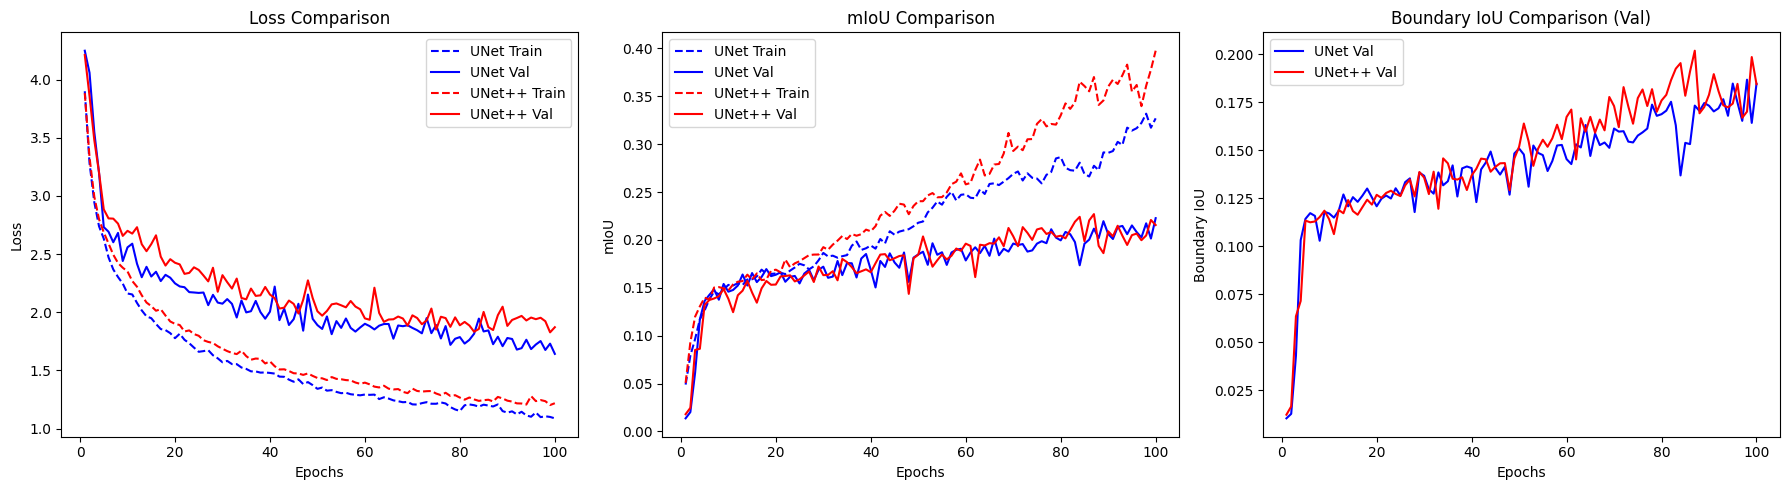

In [ ]:
if __name__ == '__main__':
    # main() 함수 실행
    main()
